## LOAD MODULES

In [1]:
#import standard modules
%run ../load_main.py
from WRFChemToolkit.analysis import aerosols_202 as aer, plots as pt, statistics as st, IGP as igp

#for getting only IGP data
import salem
shp_igp= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599/phd_work/IGP/gadm_data/IGP/IGP.shp")

WRFchem outputs data path is: dpath=/geos/d21/s1878599/IGP


## Create functions for calculating emissions 

In [2]:
def calc_hour_emibio(ds,sres):
    """
    Convert isoprenes emissions rate mol km^-2 hr^-1 to hourly emission at each gridpoint Gg hr-1.
    """
    #t_res time resoluton of outputs
    gGg=1e-9 #g to Gg
    mw_isp = 68  # g/ml molar weight of isoprene

    ds["tot_emi_BISOP"]=ds["MEBIO_ISOP"]*mw_isp*(sres**2)*gGg
    ds["tot_emibio"]= ds["tot_emi_BISOP"]  
    
    ds["tot_emi_BISOP"].attrs["units"]="Gg hour^-1"
    ds["tot_emibio"].attrs["units"]="Gg hour^-1"

## Calculate emissions difference

In [3]:
# load outputs data
oab_pth=dpath+'/outputs/autumn/wrfout_d01_2017-11-01_00:00:00_.nc'
owb_pth=dpath+'/outputs/winter/wrfout_d01_2018-01-22_00:00:00_.nc'
omb_pth=dpath+'/outputs/monsoon/wrfout_d01_2017-07-17_00:00:00_.nc'
opmb_pth=dpath+'/outputs/premonsoon/wrfout_d01_2017-05-02_00:00:00.nc'

oap_pth=dpath+'/outputs/autumn/bio_prtb/wrfout_d01_2017-11-01_00:00:00_isop.nc'
owp_pth=dpath+'/outputs/winter/bio_ptrb/wrfout_d01_2018-01-22_00:00:00_isop.nc'
omp_pth=dpath+'/outputs/monsoon/bio_ptrb/wrfout_d01_2017-07-17_00:00:00_isop.nc'
opmp_pth=dpath+'/outputs/premonsoon/bio_ptrb/wrfout_d01_2017-05-02_00:00:00_isop.nc'

oab= xr.open_mfdataset(oab_pth).sel(Time=slice(1,56)) # get period from 1 nov to 8 nov without 
oap=xr.open_mfdataset(oap_pth).sel(Time=slice(1,56))  # output perturbed 
owb= xr.open_mfdataset(owb_pth).sel(Time=slice(1,56)) # get period from 22 jan to 29 nov
owp=xr.open_mfdataset(owp_pth).sel(Time=slice(1,56))  # output perturbed 
opmb= xr.open_mfdataset(opmb_pth).sel(Time=slice(1,56)) # get period from 2 may to 8 may
opmp=xr.open_mfdataset(opmp_pth).sel(Time=slice(1,56))  # output perturbed 
omb=xr.open_mfdataset(omb_pth).sel(Time=slice(1,56)) # get period from 17 july to 24 july
omp=xr.open_mfdataset(omp_pth).sel(Time=slice(1,56)) # output perturbed 

# put everything in a dict by season
bout={"aut":[oab,oap], "win":[owb,owp],"pmon":[opmb,opmp],"mon":[omb,omp]}

In [4]:
#Calculate total emissions at each gridpoint at each output time step. [Gg]

t_res =3 # output frequency in h.
for v in bout.values(): # v is list of datasets.
    for ds in v: 
        calc_hour_emibio(ds,sres=20)
        ds["tot_emibio"]=ds["tot_emibio"]*t_res #ouputs are every 3 hours: need to multiply by 3 each  emission output.

### Calculate total emissions difference for the perturbed period in the whole IGP

In [5]:
emitot_igp={'pmon': {}, 'mon': {}, 'aut': {}, 'win': {}}
for s in bout.keys():
    v0igp=bout[s][0].salem.roi(shape=shp_igp)
    v1igp=bout[s][1].salem.roi(shape=shp_igp)
    d= (v1igp["tot_emibio"]-v0igp["tot_emibio"]).sum(dim=['Time',"south_north","west_east"]).values
    emitot_igp.update({s:d})

In [6]:
emitot_igp

{'pmon': array(2.1292639, dtype=float32),
 'mon': array(2.7085993, dtype=float32),
 'aut': array(1.0243684, dtype=float32),
 'win': array(0.26809245, dtype=float32)}

### Calculate weighted total emissions difference for the perturbed period in the whole IGP

In [7]:
# Calculate weights (number of gridcells with emissions 2.8Mg during the simulation period).
weight_igp={'pmon': {}, 'mon': {}, 'aut': {}, 'win': {}}
diff={'pmon': {}, 'mon': {}, 'aut': {}, 'win': {}}
for s in bout.keys():
        per= bout[s][1].salem.roi(shape=shp_igp)['tot_emibio'].sum(dim=['Time'])
        base= bout[s][0].salem.roi(shape=shp_igp)['tot_emibio'].sum(dim=['Time'])
        d=per-base
        diff.update({s:d})
        w = np.count_nonzero(d.values>2.8e-3) # 2.8 Mg correspod to a rate of 0.001 g m-2 day-1.
        weight_igp.update({s:w})

In [8]:
weight_igp

{'pmon': 89, 'mon': 102, 'aut': 6, 'win': 0}

In [9]:
# Calculate weighted emissions
w_emitot_igp={'pmon': {}, 'mon': {}, 'aut': {}, 'win': {}}
for s in emitot_igp.keys():
    we=emitot_igp[s]/weight_igp[s]
    w_emitot_igp.update({s:we})

In [10]:
w_emitot_igp

{'pmon': 0.02392431323447924,
 'mon': 0.02655489538230148,
 'aut': 0.170728067557017,
 'win': inf}

## Prepare aerosols outputs

In [11]:
# put everything in a dict by season
sbout={"aut":[oab,oap], "win":[owb,owp],"pmon":[opmb,opmp],"mon":[omb,omp]}

In [12]:
#get aerosols.
aaer={}
for k,v in sbout.items():
    
    baer= aer.get_aerosols(v[0])
    baer.attrs=v[0].attrs
    paer= aer.get_aerosols(v[1])
    paer.attrs=v[1].attrs
    
    aaer.update({k : [baer,paer]})

## Calculate sensitivities

In [13]:
#Create function for surface sensitivity at gridpoint ij for a specified species.

def get_s_ij(bds,pds,delta_emi,var,thres):
    """
    bds = base output.
    pds = perturbed output.
    delta_emi = total difference in emissions [Gg].
    var = variable for which calculate sensitivity.
    thres= threshold in aerosols difference for calculating senstivity  [ug m-3].
    """
    # surface total difference in concentration over sim period [ug/m3].
    diff_var = (pds[var].sum(dim ='Time')-bds[var].sum(dim ='Time'))[0, :, :]
    
    # Apply threshold and put nan to zero.
    diff_masked = diff_var.where(diff_var.values>thres) 
    diff_masked.values=np.nan_to_num(diff_masked.values, copy=False,nan=0.0, posinf=0.0, neginf=0.0)

    # compute sensitivity.
    s = diff_masked/delta_emi
    return xr.Dataset({'sty':s},coords=dict(bds.coords))
    

# calculate sensitivities for all season and put in a dict.
def sensitivity(do,de,var,thres):
    "do= output dict,de=emissions dict,var=varname thres=sesnitivity calcualtion treshold "
    
    shdfigp= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599/phd_work/IGP/gadm_data/IGP/IGP.shp")
    s={}
    for k in do.keys():
        
        sens= get_s_ij(do[k][0],do[k][1],de[k],var,thres) # calc sensitivity.
        sens.attrs=do[k][0].attrs 
        
        sens_igp = sens.salem.roi(shape=shdfigp)  # get sensitivity only for IGP area.
        s.update({k:sens_igp})

    return s

In [14]:
# calculate sensitivities for PM2.5
spm25=sensitivity(aaer,w_emitot_igp,"pm25_tot",thres=4)

In [15]:
# calculate sensitivities for POA
sPOA=sensitivity(aaer,w_emitot_igp,"pm10_POA",thres=1)

In [16]:
# calculate sensitivities for SOA
sSOA=sensitivity(aaer,w_emitot_igp,"pm10_SOA",thres=1)

In [17]:
# calculate sensitivities for OA
sOA=sensitivity(aaer,w_emitot_igp,"pm10_OA",thres=1)

## PLOTS

In [18]:
#SPATIAL PLOT FUNCTION

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.colorbar import colorbar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader

def set_formatter(axes,leftlab):
    for ax in axes:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.3, color='k', alpha=0.4, linestyle='-')
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.xlocator = mticker.FixedLocator([70,80,90])
        gl.ylocator = mticker.FixedLocator([25,30])
        gl.xlabel_style = {'size': 11,'color': 'grey'}
        gl.ylabels_right = False
        gl.ylabels_left = False
        
        if leftlab==True:
            gl.ylabels_left = True
            gl.ylocator = mticker.FixedLocator([25,30])
            gl.ylabel_style = {'size': 11,'color': 'grey'}
        
        #ax.add_feature(cfeature.COASTLINE, lw=0.5)
        #ax.add_feature(cfeature.BORDERS, lw=0.5)
        
    # get lon values only n the last ax
        if ax==axes[3]:
            gl.xlabels_bottom = True
            gl.xlocator = mticker.FixedLocator([70,80,90])
            gl.xlabel_style = {'size': 11,'color': 'grey'}
    
    
def set_admin(axes, shp_path):
    for ax,shp in zip(axes,shp_path):
            admin = list(shpreader.Reader(shp).geometries())
            # Add data from Global Administrative Areas Dataset GDAM https://gadm.org/index.html
            ax.add_geometries(admin, ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', alpha=1, lw=0.3)
            


def sensplot(lat,lon,pmds,mds,ads,wds,panels=["(c)","(f)","(i)","(l)"],vmin=None,vmax=None,title=None, label=None, leftlab=False,bar=False,axs=False, cmap="OrRd",levs=10, 
            delta=50,figsize=[7, 10],format="%.2f",save=False,spath=None,name="plot",savef='pdf', dpi=100):

    fig, axes =plt.subplots(nrows=4,ncols=1,figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})
    
    igp_shp="/exports/csce/datastore/geos/users/s1878599/phd_work/IGP/gadm_data/IGP/IGP.shp"
    shp_path=(igp_shp,igp_shp,igp_shp,igp_shp)
    
    set_formatter(axes.flatten(),leftlab)
    set_admin(axes.flatten(), shp_path)
 
    #Getting values.
    
    vpm=pmds[:,:].values
    vm= mds[:,:].values 
    va= ads[:,:].values 
    vw= wds[:,:].values
   
    import math
    if vmax is None:  # Get the max value in the array to plot.
        vmax =np.array([np.nanmax(vpm),np.nanmax(vm),np.nanmax(va),np.nanmax(vw)]).max() 
    if vmin is None:  # Get the max value in the array to plot.
        vmin =np.array([np.nanmin(vpm),np.nanmin(vm),np.nanmin(va),np.nanmin(vw)]).min()  
    print(vmin,vmax)
    l = np.linspace(vmin, vmax, levs)  # number of levels for which divide the bar. Customise 
    # premonsoon
    cspm=axes[0].contourf(lon,lat,vpm,transform=ccrs.PlateCarree(),cmap=cmap, vmin=vmin,vmax=vmax,levels=l,
                            extend="both")
    cspm.cmap.set_over("#FF0000")
    cspm.cmap.set_under("#FFFFFF")
                                                 
    # monsoon
    csm=axes[1].contourf(lon,lat,vm,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax,levels=l,
                              extend="both") 
    csm.cmap.set_over("#FF0000")
    csm.cmap.set_under("#FFFFFF")
    #autumn
    csa=axes[2].contourf(lon,lat,va,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax,levels=l,
                           extend="both")
    csa.cmap.set_over("#FF0000")
    csa.cmap.set_under("#FFFFFF")
    #winter
    csw=axes[3].contourf(lon,lat,vw,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax,levels=l,
                           extend="both")
    csw.cmap.set_over("#FF0000")
    csw.cmap.set_under("#FFFFFF")
    
    if axs==True:
        axes[0].text(-0.2, 0.55, 'PRE-MONSOON', va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor', fontsize=10,
        transform=axes[0].transAxes)
        axes[1].text(-0.2, 0.55, 'MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=10,
        transform=axes[1].transAxes)
        axes[2].text(-0.2, 0.55, 'POST-MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=10,
        transform=axes[2].transAxes)
        axes[3].text(-0.2, 0.55, 'WINTER', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=10,
        transform=axes[3].transAxes)
    
    
    #add panel boxes
    panels=panels
    for ax,p in zip(fig.axes,panels):
        ax.annotate(p, xy=(1, 1), xytext=(-5, -5), fontsize=12,
        xycoords='axes fraction', textcoords='offset points',
        bbox=dict(facecolor='white',edgecolor='white', alpha=0.8),
        horizontalalignment='right', verticalalignment='top')
    
    if bar==True:
    #fig.subplots_adjust(right=0.8,hspace=0.4) 
        cbar_ax = fig.add_axes([0.92, 0.1, 0.05, 0.8])  #[left, bottom, width, height]
        cbar= fig.colorbar(csw, cax=cbar_ax,pad=0.35,shrink=1, format=format)
        cbar.set_label(label,fontsize=12)
        cbar.ax.tick_params(labelsize='medium')
        cbar.set_ticks(list(range(0, vmax+delta, delta)))

    if title is not None:
        axes[0].set_title(title, fontsize=12,pad=20)
    
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.0)
    
    #save
    if save:
        plt.savefig( spath + name +'.' + savef, format=savef, dpi=dpi, bbox_inches = "tight")
    
    fig.show()

In [19]:
# define lat lon
lon =spm25["aut"].XLONG[0,:, :]
lat =spm25["aut"].XLAT[0,:, :]

0.0 1000


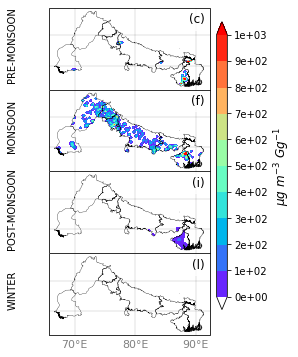

In [25]:
#PM2.5
savepth="./"
sensplot(lat,lon,spm25["pmon"].sty,spm25["mon"].sty,spm25["aut"].sty,spm25["win"].sty,cmap='rainbow',axs=True,bar=True,leftlab=False, vmax=1000,
        spath=savepth,levs=11,format="%.e",delta=100,figsize=[3,5],name='bio_pm25',save=True,savef='png',dpi=300,label='$\mu g~m^{-3}~Gg^{-1}$') 

0.0 300


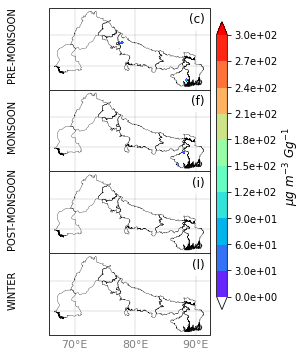

In [22]:
#POA
sensplot(lat,lon,sPOA["pmon"].sty,sPOA["mon"].sty,sPOA["aut"].sty,sPOA["win"].sty,cmap="rainbow",vmax=300,axs=True,bar=True,leftlab=False,label='$\mu g~m^{-3}~Gg^{-1}$',
        levs=11,format="%.1e",delta=30,figsize=[3,5],save=True, spath=savepth,name='bio_poa',savef='png', dpi=300)

0.0 500


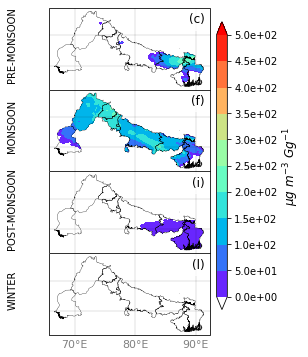

In [23]:
#OA
sensplot(lat,lon,sOA["pmon"].sty,sOA["mon"].sty,sOA["aut"].sty,sOA["win"].sty,cmap="rainbow",axs=True,bar=True,leftlab=False,label='$\mu g~m^{-3}~Gg^{-1}$',vmax=500,
        
        levs=11,delta=50,format="%.1e",figsize=[3,5],save=True,spath=savepth,name="bio_oa",savef='png', dpi=300)

0.0 300


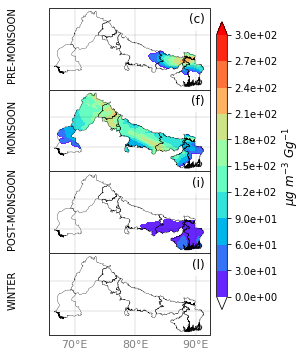

In [24]:
#SOA
sensplot(lat,lon,sSOA["pmon"].sty,sSOA["mon"].sty,sSOA["aut"].sty,sSOA["win"].sty,cmap="rainbow",axs=True,bar=True,leftlab=False,spath=savepth,vmax=300,label='$\mu g~m^{-3}~Gg^{-1}$',
        levs=11,delta=30,format="%.1e",figsize=[3,5],save=True,name="bio_soa",savef='png', dpi=300)